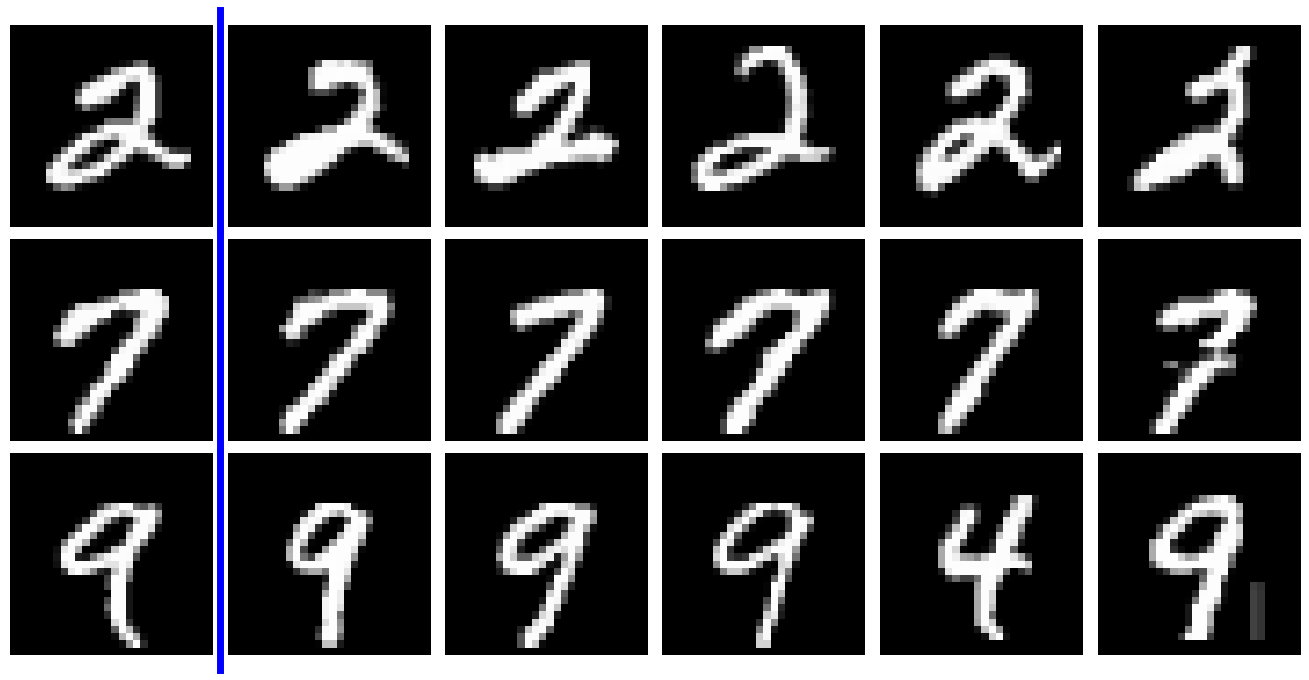

In [ ]:
import os
import random
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# -----------------------------
# 1) Load MNIST (training split)
# -----------------------------
transform = transforms.ToTensor()  # float tensor in [0,1], shape [1, 28, 28]
train_ds = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# ------------------------------------------------
# 2) Build a (random) subset of the training data
# ------------------------------------------------
subset_size = 3000  # adjust as desired
subset_indices = set(random.sample(range(len(train_ds)), subset_size))

subset_imgs = []
subset_labels = []
for idx in subset_indices:
    img, lbl = train_ds[idx]
    subset_imgs.append(img)   # [1, 28, 28]
    subset_labels.append(lbl)

subset_imgs = torch.stack(subset_imgs, dim=0)             # [N, 1, 28, 28]
subset_labels = torch.tensor(subset_labels, dtype=torch.long)  # [N]
subset_flat = subset_imgs.view(subset_imgs.size(0), -1)   # [N, 784]

# ------------------------------------------------------
# 3) Select "key" examples (2, 7, 9) NOT in the subset
# ------------------------------------------------------
def find_example_not_in_indices(ds, digit, excluded_indices):
    for i in range(len(ds)):
        if i in excluded_indices:
            continue
        img, lbl = ds[i]
        if lbl == digit:
            return img, lbl, i
    raise ValueError(f"Digit {digit} not found outside the excluded indices.")

key_digits = [2, 7, 9]
keys = []  # list of (key_img, key_lbl, key_idx)
for d in key_digits:
    kimg, klbl, kidx = find_example_not_in_indices(train_ds, d, subset_indices)
    keys.append((kimg, klbl, kidx))  # each kimg shape [1,28,28]

# ---------------------------------------------------------------
# 4) For each key, find the 5 nearest neighbors in the subset
#    by L2 distance in pixel space (subset is the only pool)
# ---------------------------------------------------------------
def topk_neighbors_l2(key_img, pool_flat, k=5):
    key_vec = key_img.view(1, -1)          # [1, 784]
    dists = torch.cdist(key_vec, pool_flat, p=2).squeeze(0)  # [N]
    vals, idxs = torch.topk(dists, k, largest=False)
    return idxs, vals

k = 5
neighbors_per_key = []  # (key_img, key_lbl, neighbor_imgs[k], neighbor_lbls[k], dists[k])
for (kimg, klbl, _) in keys:
    idxs, dists = topk_neighbors_l2(kimg, subset_flat, k=k)
    nb_imgs = subset_imgs[idxs]    # [k, 1, 28, 28]
    nb_lbls = subset_labels[idxs]  # [k]
    neighbors_per_key.append((kimg, klbl, nb_imgs, nb_lbls, dists))

# ---------------------------------------------------------------
# 5) Plot: one row per key (2, 7, 9). Each row shows:
#    [key] | [NN1] [NN2] [NN3] [NN4] [NN5]
# ---------------------------------------------------------------
rows = len(key_digits)
cols = 1 + k
fig, axes = plt.subplots(rows, cols, figsize=(2.2*cols, 2.2*rows))
if rows == 1:
    axes = axes[None, :]  # ensure 2D indexing if only one row

for r, (kimg, klbl, nb_imgs, nb_lbls, dists) in enumerate(neighbors_per_key):
    # First column: the key
    ax = axes[r, 0]
    ax.imshow(kimg.squeeze(0), cmap="gray")
    ax.axis("off")

    # Next columns: neighbors
    for c in range(k):
        ax = axes[r, 1 + c]
        ax.imshow(nb_imgs[c].squeeze(0), cmap="gray")
        ax.axis("off")

    # Draw a vertical line separating key and neighbors
    # We add it to the whole row figure, not just one subplot
    fig.add_artist(plt.Line2D(
        [1.025/cols, 1.025/cols],     # x-position in figure coordinates
        [r/rows, (r+1)/rows], # from top of this row to bottom
        transform=fig.transFigure,
        color="blue", linewidth=5
    ))

# Optional row labels (left side)
for r in range(rows):
    axes[r, 0].set_ylabel(f"Digit {key_digits[r]}", rotation=90,
                          fontsize=12, labelpad=10)

plt.tight_layout()

import os
os.makedirs("images", exist_ok=True)
plt.savefig("images/kernel_mnist_knn.svg", dpi=300)

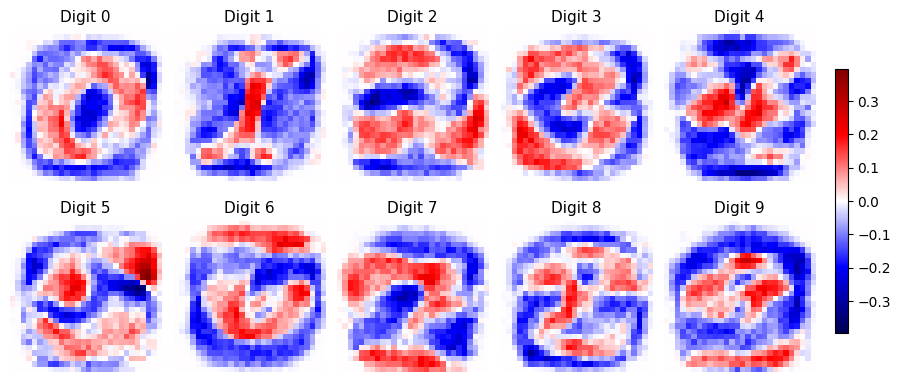

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# -----------------------------
# 1) Data
# -----------------------------
transform = transforms.ToTensor()  # [1,28,28] in [0,1]
train_ds = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)

# -----------------------------
# 2) Model: multinomial logistic regression (softmax)
# -----------------------------
class SoftmaxLogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10, bias=True)
    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten to [B,784]
        return self.linear(x)      # logits [B,10]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
model = SoftmaxLogReg().to(device)

# -----------------------------
# 3) Train
# -----------------------------
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

epochs = 3  # increase to 5–10 for crisper weights
model.train()
for _ in range(epochs):
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        opt.step()

# -----------------------------
# 4) Visualize class weights
# -----------------------------
with torch.no_grad():
    W = model.linear.weight.detach().cpu().view(10, 28, 28)  # [10,28,28]
    vmax = W.abs().max().item()  # shared symmetric scale

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.reshape(2, 5)

for d in range(10):
    r, c = divmod(d, 5)
    ax = axes[r, c]
    im = ax.imshow(W[d].numpy(), cmap="seismic", vmin=-vmax, vmax=vmax)
    ax.set_title(f"Digit {d}", fontsize=11)
    ax.axis("off")

plt.tight_layout()

# Optional: one shared colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.75, pad=0.02)
cbar.set_label("", rotation=90)
plt.savefig('images/kernel_mnist_weights.svg', dpi=300)